# Fake Image Detection with ELA and CNN

Agus Gunawan, Holy Lovenia, Adrian Hartanto Pramudita

For more information: [Indonesian documentation](https://github.com/agusgun/FakeImageDetector/blob/master/docs/Deteksi%20Pemalsuan%20Gambar%20dengan%20ELA%20dan%20Deep%20Learning.pdf)

![full-architecture](docs/model-architecture.jpg "Architecture")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


## Initial preparation

In [2]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

#### Functions

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [4]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

### Sample: Real Image

Let's open a real (not-fake) image as a sample.

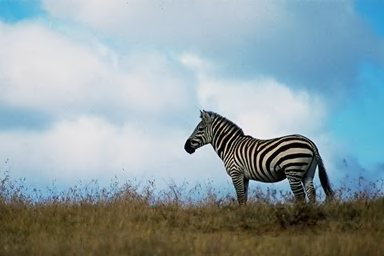

In [20]:
Image.open('datasets/train/real/Au_ani_00001.jpg')

This is how it looks like after it is processed with error-level analysis (ELA).

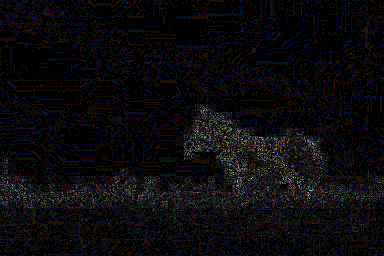

In [21]:
convert_to_ela_image('datasets/train/real/Au_ani_00001.jpg', 90)

### Sample: Fake Image

This is how it looks like after it has been edited.

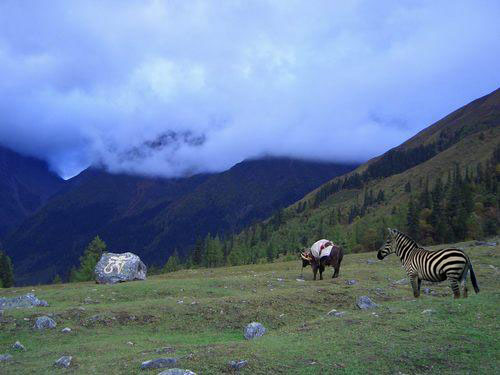

In [22]:
Image.open('datasets/train/fake/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg')

This is the result of the fake image after getting through ELA. We can compare the difference between the picture below and the real picture's ELA result.

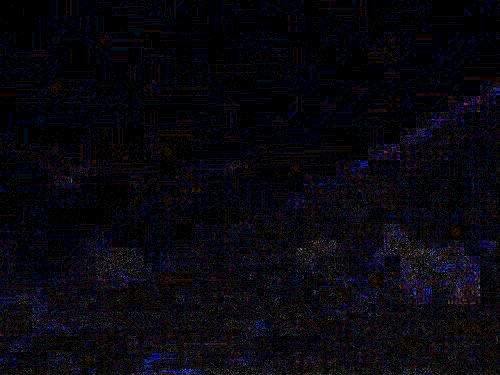

In [23]:
convert_to_ela_image('datasets/train/fake/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg', 90)

With our own naked eyes, we are able to differ which is the ELA result of the real picture and which one is the result of fake image. By saying real here, what we mean is a non-CGI picture that is not fabricated/edited in any way, e.g. splicing.

## Data preparation

### Read dataset and conversion to ELA

In [5]:
dataset = pd.read_csv('datasets/dataset.csv')

In [6]:
X = []
Y = []

In [7]:
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])

### Normalization

In [8]:
X = np.array(X)
Y = to_categorical(Y, 2)

### Reshape X

In [9]:
X = X.reshape(-1, 128, 128, 3)

## Train-test split

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

## CNN building

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

### Add optimizer

In [14]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)


In [15]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


### Define early stopping

In [16]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

### Model training

In [17]:
epochs = 30
batch_size = 100

In [18]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Train on 3768 samples, validate on 943 samples
Epoch 1/30
 - 10s - loss: 0.6697 - acc: 0.6340 - val_loss: 0.5249 - val_acc: 0.6204
Epoch 2/30
 - 7s - loss: 0.4549 - acc: 0.7914 - val_loss: 0.5951 - val_acc: 0.7349
Epoch 3/30
 - 6s - loss: 0.3670 - acc: 0.8442 - val_loss: 0.3119 - val_acc: 0.8791
Epoch 4/30
 - 6s - loss: 0.3398 - acc: 0.8559 - val_loss: 0.3380 - val_acc: 0.8706
Epoch 5/30
 - 6s - loss: 0.2860 - acc: 0.8933 - val_loss: 0.3196 - val_acc: 0.8802
Epoch 6/30
 - 6s - loss: 0.2690 - acc: 0.9007 - val_loss: 0.2350 - val_acc: 0.9120
Epoch 7/30
 - 6s - loss: 0.2080 - acc: 0.9220 - val_loss: 0.2313 - val_acc: 0.9141
Epoch 8/30
 - 6s - loss: 0.1941 - acc: 0.9217 - val_loss: 0.5936 - val_acc: 0.8208
Epoch 9/30
 - 6s - loss: 0.1603 - acc: 0.9392 - val_loss: 0.2067 - val_acc: 0.9183
Epoch 10/30
 - 6s - loss: 0.1402 - acc: 0.9477 - val_loss: 0.2137 - val_acc: 0.9120
Epoch 11/30
 - 6s - loss: 0.1306 - acc: 0.9498 - val_loss: 0.2088 - val_acc: 0.9088


## Performance measure

### Accuracy and loss curves during training-validation

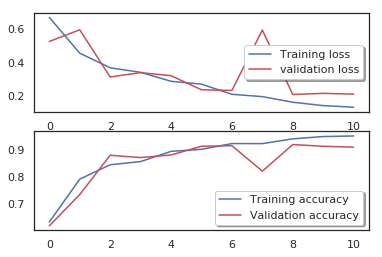

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

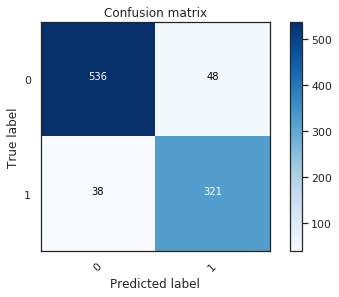

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))